# Imports e carregamentos

In [10]:
import pandas as pd

import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

In [12]:
df.value_counts('result')

result
0    45905
1    45905
Name: count, dtype: int64

In [13]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'shotsHome', 'shotsAway',
       'blockedShotsHome', 'blockedShotsAway', 'league', 'corners_home',
       'corners_away', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'shotsOngoal_away', 'yellowcards_home',
       'yellowcards_away', 'fouls_home', 'fouls_away', 'offsides_home',
       'offsides_away', 'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'shotsOnGoalEfficiency',
       'attackPressure', 'shotAccuracy_home', 'shotAccuracy_away',
       'possessionControl', 'passRisk', 'defensiveDiscipline',
       'defensiveEfficacy', 'defensiveAggression'],
      dtype='object')

## Preprocessamento

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    return preprocessor.fit(X)
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)

# Salvando o preprocessador para uso futuro
pickle.dump(preprocessor, open('../models/preprocessor.pickle', 'wb'))

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)


                                                                                   
Generation 1 - Current best internal CV score: 0.8559525197281823
                                                                                   
Generation 2 - Current best internal CV score: 0.8701802374912649
                                                                                   
Generation 3 - Current best internal CV score: 0.8701802374912649
                                                                                   
Generation 4 - Current best internal CV score: 0.8792206418523264
                                                                                   
Generation 5 - Current best internal CV score: 0.8792206418523264
                                                              
Best pipeline: KNeighborsClassifier(StandardScaler(input_matrix), n_neighbors=1, p=2, weights=distance)


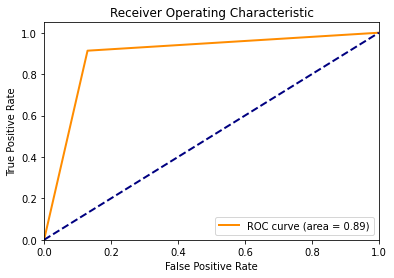

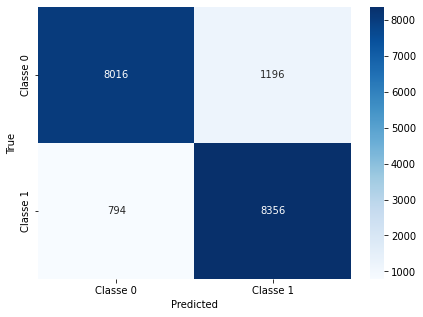

Relatório de Classificação:
               precision    recall  f1-score   support

    Classe 0       0.91      0.87      0.89      9212
    Classe 1       0.87      0.91      0.89      9150

    accuracy                           0.89     18362
   macro avg       0.89      0.89      0.89     18362
weighted avg       0.89      0.89      0.89     18362



In [15]:
from tpot import TPOTClassifier
from sklearn.metrics import classification_report

# Inicializando TPOT
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Salvando o pipeline otimizado
# tpot.export('tpot_exported_pipeline.py')

# Avaliação do Modelo
y_pred_prob = tpot.predict_proba(X_test)[:, 1]  # pegar as probabilidades da classe 1
y_pred = tpot.predict(X_test)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualizar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1']))


In [16]:
# Salvar o modelo TPOT
with open('../models/tpot_model.pkl', 'wb') as file:
    pickle.dump(tpot.fitted_pipeline_, file)

In [8]:
df.head(1699).tail(1)['result']

1698    1
Name: result, dtype: int64

In [9]:
model_Automl = pickle.load(open('../models/tpot_model.pkl', 'rb'))

# na prática
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
yht = df['result'].head(1699).tail(1)

model_Automl.predict(Xht)[0] > 0  # pegar as probabilidades da classe 1

True

## H2O AutoML

### Conversão de Dados a Treinamento

In [ ]:
# Função para converter para H2OFrame
def convert_to_h2oframe(X, y):
    
    X_h2o = h2o.H2OFrame(pd.DataFrame(X))
    y_h2o = h2o.H2OFrame(pd.DataFrame(y, columns=["result"]))

    if X_h2o.shape[0] > y_h2o.shape[0]:
        X_train_h2o = X_train_h2o.head(rows=y_h2o.shape[0])
        # Verificando as formas após ajustar
        print("Shapes após ajustar X_train_h2o:")
        print("X_train_h2o shape:", X_train_h2o.shape)
        print("y_train_h2o shape:", y_h2o.shape)
        
    return X_h2o.cbind(y_h2o)

In [ ]:
# # # Inicializar o H2O
# h2o.init()

# # # Convertendo dados para H2OFrame
# X_train_h2o = h2o.H2OFrame(X_train)
# y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))

# # Verifique as formas após a conversão
# print("Shapes após a conversão para H2OFrame:")
# print("X_train_h2o shape:", X_train_h2o.shape)
# print("y_train_h2o shape:", y_train_h2o.shape)

# # Se X_train_h2o tem uma linha a mais, remova a última linha
# if X_train_h2o.shape[0] > y_train_h2o.shape[0]:
#     X_train_h2o = X_train_h2o.head(rows=y_train_h2o.shape[0])
#     # Verificando as formas após ajustar
#     print("Shapes após ajustar X_train_h2o:")
#     print("X_train_h2o shape:", X_train_h2o.shape)
#     print("y_train_h2o shape:", y_train_h2o.shape)

# X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["C" + str(i) for i in range(X_test.shape[1])]))
# y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# # Verifique as formas após a conversão
# print("Shapes após a conversão para H2OFrame:")
# print("X_test_h2o shape:", X_test_h2o.shape)
# print("y_test_h2o shape:", y_test_h2o.shape)

# # Se X_test_h2o tem uma linha a mais, remova a última linha
# if X_test_h2o.shape[0] > y_test_h2o.shape[0]:
#     X_test_h2o = X_test_h2o.head(rows=y_test_h2o.shape[0])
#     # Verificando as formas após ajustar
#     print("Shapes após ajustar X_test_h2o:")
#     print("X_test_h2o shape:", X_test_h2o.shape)
#     print("y_test_h2o shape:", y_test_h2o.shape)


# # Combinação dos dados
# train_data = X_train_h2o.cbind(y_train_h2o)
# test_data = X_test_h2o.cbind(y_test_h2o)

# # Identificação de preditores e resposta
# x = train_data.columns

# y = "result"
# x.remove(y)


# Convertendo dados para H2OFrame
train_data, test_data = convert_to_h2oframe(X_train, y_train), convert_to_h2oframe(X_test, y_test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Treinamento

In [ ]:
# Converta a coluna de resposta em categórica
train_data['result'] = train_data['result'].asfactor()

# Run AutoML
aml = H2OAutoML(max_models=20, sort_metric='aucpr')
aml.train(y='result', training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

AutoML progress: |█
18:03:08.187: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    aucpr       auc    logloss    mean_per_class_error      rmse       mse
StackedEnsemble_BestOfFamily_1_AutoML_3_20231208_180308  0.873038  0.878657   0.439377                0.203786  0.375022  0.140642
StackedEnsemble_AllModels_1_AutoML_3_20231208_180308     0.872953  0.878641   0.439422                0.206685  0.375047  0.14066
GBM_grid_1_AutoML_3_20231208_180308_model_4              0.870752  0.875773   0.458278                0.209504  0.383522  0.147089
DRF_1_AutoML_3_20231208_180308                           0.823418  0.827143   0.581421                0.263836  0.443355  0.196563
XRT_1_AutoML_3_20231208_180308                           0.801719  0.800626   0.612278                0.29864   0.459021  0.2107
GBM_4_AutoML_3_20231208_180308                           0.

### Avaliação de métricas

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Função para imprimir a matriz de confusão
def print_confusion_matrix(y_test, y_pred_prob):
    y_pred_round = [round(value) for value in y_pred_prob]
    cm = confusion_matrix(y_test, y_pred_round)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    report = classification_report(y_test, y_pred_round, target_names=['Classe 0', 'Classe 1'])
    print("Relatório de Classificação:")
    print(report)

# Função para plotar a curva ROC
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure

# Função para avaliar o modelo
def evaluate_model(aml, test_data, y_test):
    lb = aml.leaderboard
    print(lb)

    model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)
    loaded_model = h2o.load_model(model_path)

    y_pred_prob = h2o.as_list(loaded_model.predict(test_data))['predict'].tolist()
    plot_roc_curve(y_test, y_pred_prob)
    print_confusion_matrix(y_test, y_pred_prob)

model_id                                                    aucpr       auc    logloss    mean_per_class_error      rmse       mse
StackedEnsemble_BestOfFamily_1_AutoML_3_20231208_180308  0.873038  0.878657   0.439377                0.203786  0.375022  0.140642
StackedEnsemble_AllModels_1_AutoML_3_20231208_180308     0.872953  0.878641   0.439422                0.206685  0.375047  0.14066
GBM_grid_1_AutoML_3_20231208_180308_model_4              0.870752  0.875773   0.458278                0.209504  0.383522  0.147089
DRF_1_AutoML_3_20231208_180308                           0.823418  0.827143   0.581421                0.263836  0.443355  0.196563
XRT_1_AutoML_3_20231208_180308                           0.801719  0.800626   0.612278                0.29864   0.459021  0.2107
GBM_4_AutoML_3_20231208_180308                           0.783918  0.796177   0.573692                0.291054  0.440785  0.194291
GBM_grid_1_AutoML_3_20231208_180308_model_2              0.773911  0.788304   0.569292

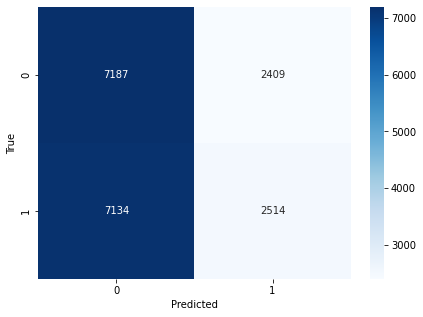

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.50      0.75      0.60      9596
    Classe 1       0.51      0.26      0.35      9648

    accuracy                           0.50     19244
   macro avg       0.51      0.50      0.47     19244
weighted avg       0.51      0.50      0.47     19244



In [ ]:
# Avaliação do Modelo
evaluate_model(aml, test_data, y_test)

### Na prática

In [ ]:
df.head(1699).tail(1)['result']

1698    1
Name: result, dtype: int64

In [ ]:
# h2o.init()
# loaded_model = h2o.load_model("../models/model_automl")
loaded_model = h2o.load_model(model_path)
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.0358635,0.964137


In [ ]:
# h2o.export_file(frame=lb, path='lb.csv', force=True)

In [ ]:
# obter o valor da predição colocando o item preditor em uma lista e pegando o primeiro valor
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


0.9641365003222852

### Importancia dos atributos

In [ ]:
# import shap
# # função de previsão para o modelo H2O
# def model_predict(data_as_array):
#     h2o_df = h2o.H2OFrame(pd.DataFrame(data_as_array, columns=["C" + str(i) for i in range(data_as_array.shape[1])]))
#     preds = loaded_model.predict(h2o_df)
#     preds_df = preds.as_data_frame()
#     # Assegurar que as previsões estejam no formato correto (array 2D com duas colunas)
#     return preds_df.iloc[:, -2:].values


# # Converter H2OFrame para DataFrame do pandas
# X_train_pd = h2o.as_list(X_train_h2o)
# X_test_pd = h2o.as_list(X_test_h2o)

# # explainer usando KernelExplainer para um modelo H2O
# explainer = shap.KernelExplainer(model_predict, X_train_pd.iloc[:50])

In [ ]:
# Calcula os valores SHAP para um subconjunto do conjunto de teste
# shap_values_h2o = explainer.shap_values(X_test_pd[:50])

In [ ]:
# # Obter os nomes das colunas numéricas
# numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# # Obter os nomes das colunas após a transformação
# # Para as características numéricas, permanecem os mesmos
# transformed_numeric_features = numeric_features

# # como so tem uma caracteristica categorica:
# categories = preprocessor.named_transformers_['cat'].categories_
# transformed_categorical_features = [
#     f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
# ]

# # Combina os dois
# all_transformed_features = transformed_numeric_features + transformed_categorical_features

# shap.summary_plot(shap_values_h2o, features=X_test_pd.iloc[:50], feature_names=all_transformed_features, max_display=X_test_pd.iloc[:50].shape[1])